In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations

%matplotlib inline

In [2]:
n_classes = 5
n_clf = n_classes * (n_classes - 1) // 2
c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,n_classes)),2))]
print(c_groups)

[(1, 0), (2, 0), (3, 0), (4, 0), (2, 1), (3, 1), (4, 1), (3, 2), (4, 2), (4, 3)]


In [3]:
def real_data():
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data


In [64]:
def synthetic_data(p, t, n_dim=2):
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    
    q0 = p*t
    q1 = p*(t-q0)
    q2 = p*(t-q0-q1)
    q3 = p*(t-q0-q1-q2)
    q4 = t-q0-q1-q2-q3
    
    q = [np.int(q0), np.int(q1), np.int(q2), np.int(q3), np.int(q4)]
    
    mean0 = np.ones(n_dim)*1
    mean1 = np.ones(n_dim)*1.5
    mean2 = np.ones(n_dim)*1.7
    mean3 = np.ones(n_dim)*0.5
    mean4 = np.ones(n_dim)*1.65
    
    
#     mean0 = np.ones(n_dim)*1
#     mean1 = np.ones(n_dim)*3
#     mean2 = np.ones(n_dim)*5
#     mean3 = np.ones(n_dim)*2.1
#     mean4 = np.ones(n_dim)*2.2
     
    var0 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var1 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var2 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var3 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var4 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    
    #g0 = np.random.multivariate_normal(mean0, np.eye(13), size=q[0])
    #g1 = np.random.multivariate_normal(mean1, np.eye(13), size=q[1])
    #g2 = np.random.multivariate_normal(mean2, np.eye(13), size=q[2])
    #g3 = np.random.multivariate_normal(mean3, np.eye(13), size=q[3])
    #g4 = np.random.multivariate_normal(mean4, np.eye(13), size=q[4])
    
    g0 = np.random.multivariate_normal(mean0, var0, size=q[0])
    g1 = np.random.multivariate_normal(mean1, var1, size=q[1])
    g2 = np.random.multivariate_normal(mean2, var2, size=q[2])
    g3 = np.random.multivariate_normal(mean3, var3, size=q[3])
    g4 = np.random.multivariate_normal(mean4, var4, size=q[4])

    
    y0 = np.asarray([0]*q[0]).reshape(q[0],1)
    y1 = np.asarray([1]*q[1]).reshape(q[1],1)
    y2 = np.asarray([2]*q[2]).reshape(q[2],1)
    y3 = np.asarray([3]*q[3]).reshape(q[3],1)
    y4 = np.asarray([4]*q[4]).reshape(q[4],1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)
    d = pd.DataFrame(data=g)

#     d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    
    plt.scatter(g0[:,0], g0[:,1], c='c')
    plt.scatter(g1[:,0], g1[:,1], c='b')
    plt.scatter(g2[:,0], g2[:,1], c='r')
    plt.scatter(g3[:,0], g3[:,1], c='g')
    plt.scatter(g4[:,0], g4[:,1], c='y')
    plt.show()
    
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])


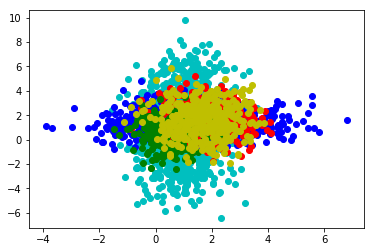

(2999, 3)
[[79  6 25 88 42]
 [28  8 60 30 18]
 [25  8 35  7 11]
 [15  1  1 35  0]
 [16  5 24 16 17]]
0.336544921487


In [65]:
#each class is 30% of a group of total data
#data = synthetic_data(0.3, 3000)

#each class is 40% of a group of total data
data = synthetic_data(0.4, 3000, 2)
print(data.shape)
#each class is 50% of a group of total data
#data = synthetic_data(0.7, 3000)

#each class is 60% of a group of total data
#data = synthetic_data(0.7, 3000)


#data = real_data()

## split data into train and test
cols = list(data.columns)
target = data[cols[-1]].copy()
cols.remove(cols[-1])
input_data = data[cols].copy()

#target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
#test removing healthy patients

#split data into train (70%), validation (10%) and test (20%)
x_train, x_test, y_train, y_test = train_test_split(input_data, target, test_size=0.20, stratify=target)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, stratify=y_train)
x_val = np.asarray(x_val)
#Scale data (z score)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
ovo.fit(x_train, y_train)

x_test = scaler.transform(x_test)
y_val_bin = label_binarize(y_val, classes=list(range(n_classes)))
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

#probas = ovo.decision_function(x_test)
#print(np.argmax(probas, axis=1))
pred_2 = ovo.predict(x_test)
#print(pred_2)
#pred = np.argmax(probas, axis=1)
#print(c_groups)
votes = np.zeros(y_test_bin.shape)
for i in range(n_clf):
    clf_ = ovo.estimators_[i]
    proba = clf_.decision_function(x_test)
    #print(proba)
    for j, p in enumerate(proba):
        #print(p)
        if p > 0:
            votes[j, c_groups[i][0]] += 1
        else:
            votes[j, c_groups[i][1]] += 1

pred = np.argmax(votes, axis=1).astype(float)
#print(votes)
#print(pred)
#unique, counts = np.unique(y_test, return_counts=True)
#print(dict(zip(unique, counts)))
cm = confusion_matrix(y_test, pred_2)
print(cm)
acc = (cm.diagonal() / cm.sum(axis=1)).sum()/n_classes
print(acc)
#test removing healthy patients

In [59]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                
## https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
def max_dor(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt_dor = -1
    for i in range(len(fpr)):
        dor = (se[i]/(1.0-se[i]))*(sp[i]/(1.0-sp[i]))
        if dor > opt_dor and not np.isinf(dor) and not np.isnan(dor):
            opt_dor = dor
            index = i
    return fpr[index], tpr[index]


/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/home/gmatos/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


1.35072624245
0.222890388313


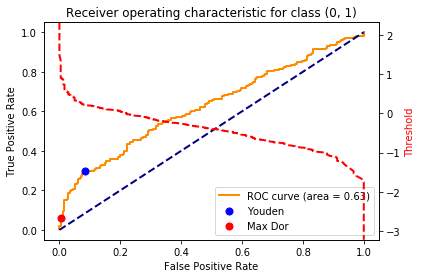

1.67139106693
0.302060010879


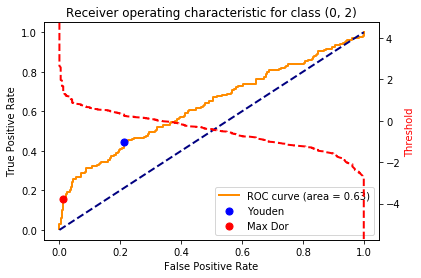

2.34386750497
2.70541802259


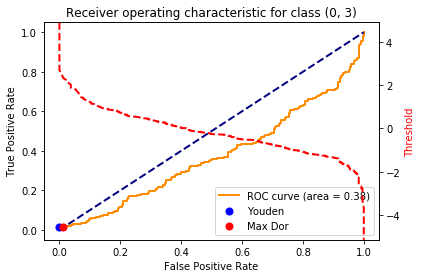

2.64022823459
0.276901895795


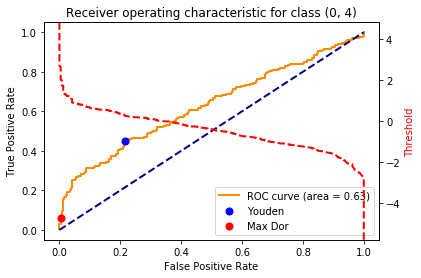

1.54364537871
1.01023750723


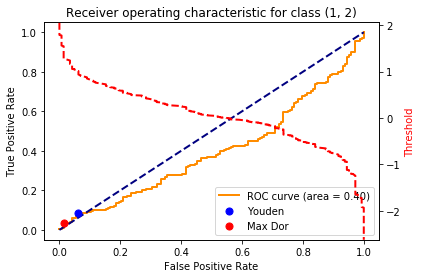

3.2072497774
0.0396121578746


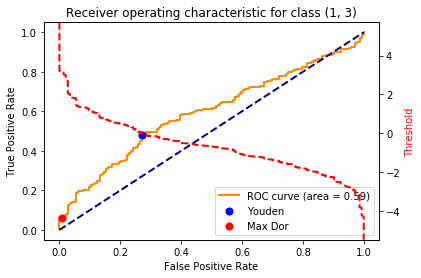

1.42260349528
1.23987186036


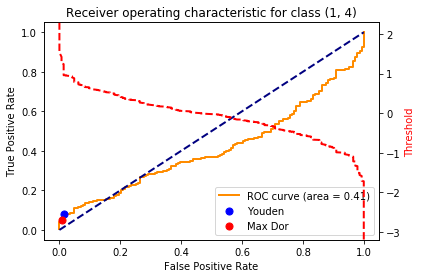

2.05416154017
0.633203124604


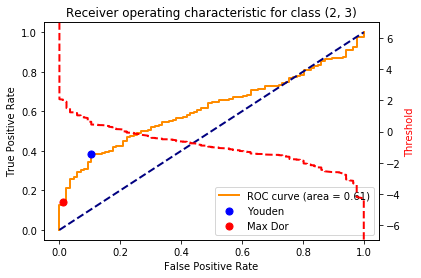

0.805915306202
0.0593136157741


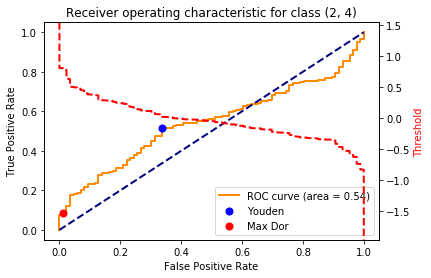

0.733908951936
0.365995095359


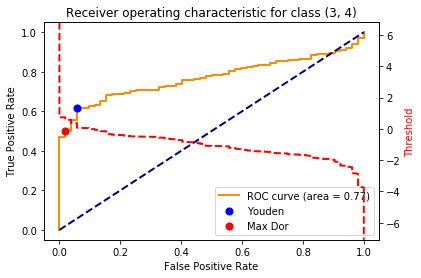

In [67]:
clf_index = 0
probas = []
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
cutpoints = dict()
#for i in range(5):
#test removing healthy patients
for i in range(n_classes):
    for j in range(n_classes):
        if j > i:
            clf = ovo.estimators_[clf_index]
            #proba = clf.predict_proba(x_test)
            proba = clf.decision_function(x_test)
            probas.append(proba)
            fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_test_bin[:, i]-1), proba)
            roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
            clf_index += 1
#for i in range(5):
#test removing healthy patients
for i in range(n_clf):
    #opt_cutpoint1 = max_sp(fpr[i], tpr[i])
    #opt_cutpoint2 = max_se(fpr[i], tpr[i])
    opt_cutpoint3 = youden_index(fpr[i], tpr[i])
    opt_cutpoint4 = max_dor(fpr[i], tpr[i])
    #print(fpr[i], tpr[i])
    #print(np.where(fpr[i] == opt_cutpoint1[0])[0][0])
    #print(np.where(fpr[i] == opt_cutpoint2[0])[0][-1])
    #c_index1 = np.where(fpr[i] == opt_cutpoint1[0])[0][0]
    #c_index2 = np.where(fpr[i] == opt_cutpoint2[0])[0][-1]
    c_index3 = np.where(fpr[i] == opt_cutpoint3[0])[0][0]
    c_index4 = np.where(fpr[i] == opt_cutpoint4[0])[0][0]
    #if c_index1 == 0:
    #    c_index1 += 1
    #if c_index2 == 0:
    #    c_index2 += 1
    if c_index3 == 0:
        c_index3 += 1
    if c_index4 == 0:
        c_index4 += 1
    
    
    cutpoints[i] = np.array([thresholds[i][c_index3], thresholds[i][c_index4]])
    #print(thresholds[i], c_index1, c_index2)
    print(thresholds[i][c_index4])
    print(thresholds[i][c_index3])
    #print(thresholds[i][c_index2])
    #print(thresholds[i][c_index1])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(tuple(reversed(c_groups[i]))))
    #ax.scatter(opt_cutpoint1[0], opt_cutpoint1[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
    #ax.scatter(opt_cutpoint2[0], opt_cutpoint2[1], c='r', zorder=1, label='MaxSe cutpoint', s=50)
    ax.scatter(opt_cutpoint3[0], opt_cutpoint3[1], c='b', zorder=1, label='Youden', s=50)
    ax.scatter(opt_cutpoint4[0], opt_cutpoint4[1], c='r', zorder=1, label='Max Dor', s=50)
    ax.legend(loc="lower right")
    
    ax2 = plt.gca().twinx()
    ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
    ax2.set_xlim([-0.05, 1.05])
    plt.savefig(os.path.join(os.getcwd(), 'heart_' + str(tuple(reversed(c_groups[i])))) + '.png')
    plt.show()

In [68]:
class_votes_c1 = np.zeros(y_test_bin.shape)
class_votes_c2 = np.zeros(y_test_bin.shape)




for i in range(n_clf):
    clf = ovo.estimators_[i]
    proba = clf.decision_function(x_test)
#     proba = probas[i]
    for j, p in enumerate(proba):
        if p > cutpoints[i][0] or np.isclose(p,cutpoints[i][0]):
            class_votes_c1[j, c_groups[i][0]] += 1
        else:
            class_votes_c1[j, c_groups[i][1]] += 1


for i in range(n_clf):
    clf = ovo.estimators_[i]
    proba = clf.decision_function(x_test)
#     proba = probas[i]
    for j, p in enumerate(proba):
        if p > cutpoints[i][1] or np.isclose(p,cutpoints[i][1]):
            class_votes_c2[j, c_groups[i][0]] += 1
        else:
            class_votes_c2[j, c_groups[i][1]] += 1
            
        #if p > cutpoints[i][0] or np.isclose(p,cutpoints[i][0]):
        #    class_votes[j, c_groups[i][0]] += 1
        #elif p < cutpoints[i][1] or np.isclose(p,cutpoints[i][1]):
        #    class_votes[j, c_groups[i][1]] += 1
        #else:
        #    class_votes[j, c_groups[i][0]] += 1
        #    class_votes[j, c_groups[i][1]] += 1 

occurrences_c1 = np.asarray([np.where(t==t.max())[0] for t in class_votes_c1])
occurrences_c2 = np.asarray([np.where(t==t.max())[0] for t in class_votes_c2])
#print(occurrences_c1)

#print(y_test)
new_preds_c1 = [p[-1] for p in occurrences_c1]
new_preds_c2 = [p[-1] for p in occurrences_c2]
#print(new_preds)
#new_preds = np.argmax(class_votes, axis=1)
#print(np.where(y_test == 1)[0].shape[0])
cm_c1 = confusion_matrix(y_test, new_preds_c1)
cm_c2 = confusion_matrix(y_test, new_preds_c2)

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
#print(y_test)
print('SVM: \n', cm)
print('Using c1(Youden): \n', cm_c1)
print('Using c2(Max DOR): \n', cm_c2)
#print(cm_2.sum(axis=0))
acc_c1 = (cm_c1.diagonal() / cm_c1.sum(axis=1)).sum()/n_classes
acc_c2 = (cm_c2.diagonal() / cm_c2.sum(axis=1)).sum()/n_classes
#print(acc_2)

print('Score 1: ', cm.diagonal().sum()/cm.sum())
print('Score Youden: ', cm_c1.diagonal().sum()/cm_c1.sum())
print('Score Max DOR: ', cm_c2.diagonal().sum()/cm_c2.sum())

#m = np.stack((new_preds, np.asarray(y_test).astype(int), pred.astype(int)), axis=0)
#print(m.T)
#print('new: ', new_preds)
#print('real: ', np.asarray(y_test).astype(int))
#print('old: ', pred.astype(int))

{0.0: 240, 1.0: 144, 2.0: 86, 3.0: 52, 4.0: 78}
SVM: 
 [[79  6 25 88 42]
 [28  8 60 30 18]
 [25  8 35  7 11]
 [15  1  1 35  0]
 [16  5 24 16 17]]
Using c1(Youden): 
 [[188   7  21   0  24]
 [ 64  48  21   5   6]
 [ 45  19  19   0   3]
 [ 51   1   0   0   0]
 [ 38  21  13   0   6]]
Using c2(Max DOR): 
 [[234   0   3   3   0]
 [114   5  20   5   0]
 [ 81   0   5   0   0]
 [ 52   0   0   0   0]
 [ 72   0   6   0   0]]
Score 1:  0.29
Score Youden:  0.435
Score Max DOR:  0.406666666667


In [52]:
#using region between cutpoints as doubt
class_votes_1 = np.zeros(y_test_bin.shape)
class_votes_2 = np.zeros(y_test_bin.shape)
class_votes_3 = np.zeros(y_test_bin.shape)


sample = np.random.randint(len(proba))
print("sample: ", sample)
print("real class: ", np.asarray(y_test)[sample])
for i in range(n_clf):
    clf = ovo.estimators_[i]
    proba = probas[i]
    p = proba[sample]
    if p > cutpoints[i].max() or np.isclose(p, cutpoints[i].max()):
        print(c_groups[i], c_groups[i][0])
    elif p > cutpoints[i].min() and p < cutpoints[i].max():
        print(c_groups[i], c_groups[i][0], ' or ', c_groups[i][1])
    elif p < cutpoints[i].min():
        print(c_groups[i], c_groups[i][1])

for i in range(n_clf):
    clf = ovo.estimators_[i]
    proba = probas[i]
    #print(p, cutpoints[i].max(), cutpoints[i].min())
    for j, p in enumerate(proba):
        if p > cutpoints[i].max() or np.isclose(p, cutpoints[i].max()):
            class_votes_1[j, c_groups[i][0]] += 1
            class_votes_2[j, c_groups[i][0]] += 1
            class_votes_3[j, c_groups[i][0]] += 1
        elif p > cutpoints[i].min() and p < cutpoints[i].max():
            class_votes_1[j, c_groups[i][0]] += 1
            class_votes_1[j, c_groups[i][1]] += 1
            class_votes_2[j, c_groups[i][0]] += 0.5
            class_votes_2[j, c_groups[i][1]] += 0.5
            class_votes_3[j, c_groups[i][0]] += 0
            class_votes_3[j, c_groups[i][1]] += 0
        elif p < cutpoints[i].min():
            class_votes_1[j, c_groups[i][1]] += 1
            class_votes_2[j, c_groups[i][1]] += 1
            class_votes_3[j, c_groups[i][1]] += 1

#for o in class_votes:
#    print(o)
    
occurrences_1 = np.asarray([np.where(t==t.max())[0] for t in class_votes_1])
occurrences_2 = np.asarray([np.where(t==t.max())[0] for t in class_votes_2])
doubt_pred = np.asarray(occurrences_2)
#print(doubt_pred.reshape(600,1))
#print(y_test)
occurrences_3 = np.asarray([np.where(t==t.max())[0] for t in class_votes_3])
#print(occurrences)
new_preds_1 = [p[-1] for p in occurrences_1]
new_preds_2 = [p[-1] for p in occurrences_2]
new_preds_3 = [p[-1] for p in occurrences_3]


print("predicted class 1: ", new_preds_1[sample])
print("predicted class 0.5: ", new_preds_2[sample])
print("predicted class 0: ", new_preds_3[sample])

#print(new_preds)
#new_preds = np.argmax(class_votes, axis=1)
cm_1 = confusion_matrix(y_test, new_preds_1)
cm_2 = confusion_matrix(y_test, new_preds_2)
cm_3 = confusion_matrix(y_test, new_preds_3)

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
#print(y_test)
print('SVM: \n', cm)
print('Using 1 vote on doubt: \n', cm_1)
print('Using half vote on doubt: \n', cm_2)
print('Using no vote on doubt: \n', cm_3)
#print(cm_2.sum(axis=0))
#acc_c1 = (cm_c.diagonal() / cm_c.sum(axis=1)).sum()/n_classes
#print(acc_2)

print('Score cutting on half: ', cm.diagonal().sum()/cm.sum())
print('Score adding one vote to both on doubt: ', cm_1.diagonal().sum()/cm_1.sum())
print('Score adding half vote to both on doubt: ', cm_2.diagonal().sum()/cm_2.sum())
print('Score adding no vote to both on doubt: ', cm_3.diagonal().sum()/cm_3.sum())

#m = np.stack((new_preds, np.asarray(y_test).astype(int), pred.astype(int)), axis=0)
#print(m.T)
#print('new: ', new_preds)
#print('real: ', np.asarray(y_test).astype(int))
#print('old: ', pred.astype(int))

sample:  503
real class:  0.0
(1, 0) 0
(2, 0) 0
(3, 0) 0
(2, 1) 1
(3, 1) 1
(4, 1) 1
(3, 2) 2
(4, 2) 2
(4, 3) 3
predicted class 1:  1
predicted class 0.5:  1
predicted class 0:  1
{0.0: 240, 1.0: 144, 2.0: 86, 3.0: 52, 4.0: 78}
SVM: 
 [[219  19   2   0   0]
 [ 10 121  13   0   0]
 [  0   7  66  13   0]
 [  0   0   4  44   4]
 [  0   0   0   6  72]]
Using 1 vote on doubt: 
 [[223  16   1   0   0]
 [ 16 123   5   0   0]
 [  0  14  67   5   0]
 [  0   1  13  30   8]
 [  0   0   0  28  50]]
Using half vote on doubt: 
 [[222  17   1   0   0]
 [ 15 124   5   0   0]
 [  0  14  68   4   0]
 [  0   1  13  30   8]
 [  0   0   0  28  50]]
Using no vote on doubt: 
 [[217  21   1   1   0]
 [ 13 117  13   1   0]
 [  0  14  65   7   0]
 [  0   0  14  29   9]
 [  0   0   0  28  50]]
Score cutting on half:  0.87
Score adding one vote to both on doubt:  0.821666666667
Score adding half vote to both on doubt:  0.823333333333
Score adding no vote to both on doubt:  0.796666666667


In [ ]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
print(ova)